In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'electronic_gen_7_testing_attn_learning_rates'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
all_data = all_data[(all_data['class'] == 'LETTERS') | (all_data['class'] == 'ELECTRONIC')]
all_data = all_data[all_data['after'].str.len() > 5]
all_data.sample(2)
len(all_data)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
7902035,598858,18,LETTERS,TEISSIER,t e i s s i e r,LETTERS,"[30, 28, 31, 17, 17, 31, 28, 35, 0]",chefs et notables au temps du protectorat : 18...
3119091,240834,8,ELECTRONIC,RubyGems.org,r u b y g e m s dot o r g,ELECTRONIC,"[35, 43, 36, 86, 53, 28, 32, 17, 74, 25, 35, 5...","there are over 70 , 000 ruby gems hosted on <S..."


32992

In [7]:
sample_data = all_data.copy()
sample_data = sample_data.reset_index(drop=True)
del(all_data)

sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] == 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

In [8]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS']
2


In [9]:
sample_data.sample(2)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
3131,77591,0,ELECTRONIC,CBC.ca,c b c dot c a,ELECTRONIC,"[21, 36, 21, 74, 21, 22, 0]",<SAMPLE> : hershey confirms smiths falls plant...
18270,428446,1,LETTERS,Htar,h t a r,LETTERS,"[45, 30, 22, 35, 0]",htar <SAMPLE> khin ( 5 march 2012 ) .


### Utils stuff

In [10]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [11]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [12]:
arr = list(sample_data['after'])
arr = [s.split(' ') for s in arr]
words_after = [EOS_TOKEN, SOS_TOKEN, UNKNOWN_WORD_TOKEN, NUMBER_WORD_TOKEN, SAMPLE_WORD_TOKEN]
words_after = words_after + sorted(list(set(np.concatenate(arr))))
words_after_index = dict((c, i) for i, c in enumerate(words_after))
words_after_by_length = sorted(words_after, key=len, reverse=True)
words_after_regex = re.compile('(' + ')|('.join(words_after_by_length) + ')')

In [13]:
len(words_after)

152

chars_after = [EOS_TOKEN, SOS_TOKEN] + sorted(list(set(list(''.join(list(sample_data['after']))))))
chars_after_index = dict((c, i) for i, c in enumerate(chars_after))
''.join(chars_after)

In [14]:
def after_sentence_to_word_indexes(sentence, include_eos=True):
    reg = re.finditer(words_after_regex, sentence)
    arr = [words_after_index[s[0]] for s in reg]
    if include_eos:
        arr += [words_after_index[EOS_TOKEN]]
    return arr
tmp = after_sentence_to_word_indexes('dot d o c')
tmp
[words_after[t] for t in tmp]

[32, 26, 92, 19, 0]

['dot', 'd', 'o', 'c', '<EOS>']

In [15]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 152])

### Samples

In [16]:
balanced_data_length = len(sample_data)
def get_random_sample(return_last = False):
    global sample_row_last
    sample_row = balanced_data_last_sample = sample_data.iloc[random.randint(1, balanced_data_length-1)]
    if return_last:
        sample_row = sample_row_last
    else:
        sample_row_last = sample_row
    
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    return sample_row['before'], a_words_ind, sample_row['class'], sample_row['sentence'].split(' ')
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after[i] for i in s_aft])
    print(s_class, s_bef, '->', s_aft_str, s_aft)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
    
    print(s_sentence)
    words_t = words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)
    print(words_t.size())

tmp()

LETTERS KPBL -> k p b l <EOS> [72, 100, 13, 76, 0]
torch.Size([1, 5, 104])
['"', '<SAMPLE>', 'facility', 'record', '"', '.']
torch.Size([1, 6, 50])


In [17]:
%%timeit
get_random_sample()

279 µs ± 9.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Model functions

In [18]:
use_cuda = True

In [19]:
MAX_ATTENTION_LENGTH = 50

In [20]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
# tmp[~tmp['before'].str.contains('/')].sample(2)

498

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
19652,456297,16,ELECTRONIC,http://www.whccamp.hhs.gov/pdfs/fr2002_documen...,h t t p colon slash slash w w w dot w h c c a ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","u . s . government printing office , whcamp we..."
16657,388660,2,ELECTRONIC,http://www.tompaine.com/articles/what_ownershi...,h t t p colon slash slash w w w dot t o m p a ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","online at <SAMPLE> karabell , oct 11 , 2008 ."


### Encoder

In [206]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.GRU(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = hidden_words.view(1, -1)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = hidden_chars.view(1, -1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        #for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
        #    hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)

        all_outputs_chars_padded = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        att_length = min(len(all_outputs_chars[0]), MAX_ATTENTION_LENGTH-1)
        all_outputs_chars_padded[0:att_length] = all_outputs_chars[0][0:att_length]
        
        output = torch.cat((output_words, output_chars), 1)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, all_outputs_chars_padded

    def init_hidden(self):
        var1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1 = var1.cuda(); var2 = var2.cuda()
        return (var1, var2)
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): GRU(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): GRU(104, 128, batch_first=True, bidirectional=True)
)

In [22]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    #s_bef, s_aft, s_class, s_sentence = get_random_sample(True)
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(tmp_encoder_output, tmp_encoder_outputs), tmp = test_encoder_single_sample()
tmp
tmp_encoder_output.size()
tmp_encoder_outputs.size()
#torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

allmusic.com


'allmusic.com'

torch.Size([1, 384])

torch.Size([50, 256])

### Decoder

In [204]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, chars_encoded_size,
                 n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(self.hidden_size+self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size+chars_encoded_size, self.hidden_size)
        
        #self.module_attn = torch.nn.ModuleList([self.emb_lin, self.dropout, self.attn, self.attn_combine])
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
        #self.module_rnn = torch.nn.ModuleList([self.rnn, self.lin_out])

    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = embedded[0]
                
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        #return embedded, attn_applied
        
        rnn_input = torch.cat((embedded, attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden[0], attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        
    def mods_split(self):
        mods = list(decoder_rnn.modules())[1:]
        for gru_index, mod in enumerate(mods):
            #print(mod)
            if type(mod) == torch.nn.modules.rnn.GRU:
                break
        return mods[:gru_index], mods[gru_index:]
        
    def mods_attn(self):
        return self.mods_split()[0]
        
    def mods_gru(self):
        return self.mods_split()[1]

decoder_rnn = DecoderRNN(input_size=len(words_after), hidden_size=tmp_encoder_output.size()[1],
                         chars_encoded_size=tmp_encoder_outputs.size()[1], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_encoder_output, tmp_encoder_outputs)
#tmp
[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (152 -> 384)
  (dropout): Dropout (p = 0.1)
  (attn): Linear (768 -> 50)
  (attn_combine): Linear (640 -> 384)
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 152)
)

[torch.Size([1, 152]), torch.Size([1, 384]), torch.Size([1, 50])]

In [205]:
tmp = [{'params': mod.parameters(), 'lr': 3} for mod in decoder_rnn.mods_attn()]
tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
tmp.append(
    {'params': encoder_rnn.parameters()}
)
tmp

[{'lr': 3, 'params': <generator object Module.parameters at 0x7f203a989ba0>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7f203a4d4ba0>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7f203a4d4eb8>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7f203a4d4c50>},
 {'params': <generator object Module.parameters at 0x7f203b2bad00>},
 {'params': <generator object Module.parameters at 0x7f203b2ba468>},
 {'params': <generator object Module.parameters at 0x7f203b2baba0>}]

# Training etc

### Accuracy

In [190]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)

    decoder_input = Variable(sos_tensor).cuda()
    decoder_hidden = encoder_output

    decoded_output = []
    decoder_attns_arr = []
    max_length = 30
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample()
tmp

('getcorrected getcorrected getcorrected eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight',
 'getcorrected getcorrected getcorrected eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight eight',
 'h t t p colon slash slash i s l a n d n e w s p a p e r s dot c a slash i s l a n d o r a slash o b j e c t slash g u a r d i a n p e r c e n t t h r e e a o n e n i n e t h r e e s e v e n o o n e o n e s i x dash o o o n e',
 ('http://islandnewspapers.ca/islandora/object/guardian%3A19370116-001',
  [59,
   124,
   124,
   100,
   23,
   117,
   117,
   65,
   113,
   76,
   5,
   87,
   26,
   87,
   33,
   141,
   113,
   100,
   5,
   100,
   33,
   109,
   113,
   32,
   19,
   5,
   117,
   65,
   113,
   76,
   5,
   87,
   26,
   92,
   109,
   5,
   117,
   92,
   13,
   6

In [26]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

NHLer          => w's w's w's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's f's || [87, 59, 76, 33, 109, 0] 
                  ['the', 'president', 'of', 'the', 'team', 'is', 'another', 'former', '<SAMPLE>', ',', 'dale', 'hawerchuk', '.']
DVDs           => deletecyberbullying aip aip aip r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's r's || [26, 138, 27, 0] 
                  ['unlike', '<SAMPLE>', 'and', 'cds', ',', 'dmd', 'do', 'not', 'have', 'metallic', 'layers', ',', 'so', 'they', 'are', 'nearly', 'transparent', '.']


In [27]:
%%time
test_model_accuracy(decoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 3.38 s, sys: 64 ms, total: 3.44 s
Wall time: 3.44 s


0.0

### Training

In [197]:
def train(s_bef, s_aft, s_sentence, optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
   
    decoder_hidden = encoder_output
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    optimizer.zero_grad()
    
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [212]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):
    global optimizer
    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    tmp = [{'params': mod.parameters(), 'lr': (lr/10)} for mod in decoder_rnn.mods_attn()]
    tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
    tmp.append(
        {'params': encoder_rnn.parameters()}
    )
    #print(tmp)
    optimizer = torch.optim.Adam(tmp, lr=lr)
    #return optimizer
    #encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    #decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             optimizer=optimizer, 
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0: # or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [208]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/electronic_gen_7_testing_attn_learning_rates_1


In [213]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

  1009  18% (   0m 1s)   2.814   |   1.82: Uboat.net -> i s s s n (✗: u b o a t dot n e t) 
  1018  36% (   0m 1s)   2.846   |   1.79: ISBN -> i s s (✗: i s b n) 
  1027  54% (   0m 1s)   2.843   |   3.17: NeighborCity.com -> a s s s t e e e e e e <EOS> <EOS> <EOS> <EOS> <EOS> (✗: n e i g h b o r c i t y dot c o m) (forcing)
  1036  72% (   0m 1s)   2.775   |   2.65: KNAG -> i s s (✗: k n a g) 
  1045  90% (   0m 1s)   2.764   |   2.52: Actg -> i s s (✗: a c t g) 


In [230]:
optimizer.param_groups[0]['lr']
optimizer.param_groups[6]['lr']

1e-05

0.0001

In [210]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 9s)   2.696   |   2.46: ISBN -> i s <EOS> <EOS> (✗: i s b n) (forcing)


In [211]:
test_model_accuracy(encoder_rnn, test_model_single_sample)

Accuracy: 0.00% (       0/   10000)


0.0

In [ ]:
train_iterations(n_iters=49000, print_every=10000)

In [ ]:
train_iterations(n_iters=50000, print_every=10000)

In [390]:
state_dict_path = 'data/models/electronic_gen_6_testing_attn/100000_'
#state_dict_path = 'data/models/electronic_gen_6_testing_attn/50000_'
decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

### Show attention

input:   SoundMeet.net
output:  i a a a a e
target:    soundmeetdotnet


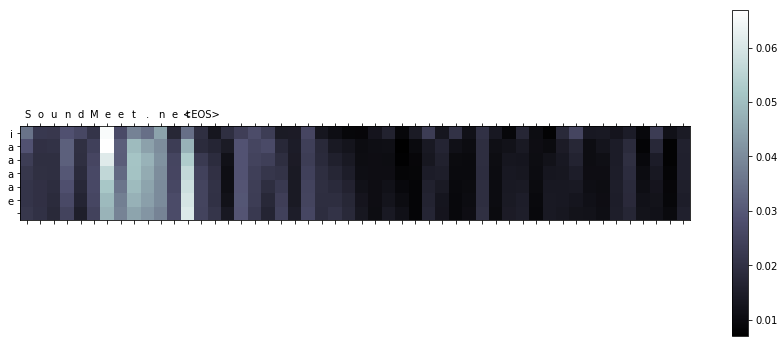

In [231]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    #inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    inp_arr = input_sentence
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    global sample_row_last
    #sample_row = balanced_data_sample_row()
    sample_row = sample_data[sample_data['before'].str.len()>10].sample(1).iloc[0]
    sample_row_last = sample_row
       
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    sample = sample_row['before'], a_words_ind, sample_row['class'], sample_row['sentence'].split(' ')

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', ' '.join(decoded_output))
    print('target:   ', ''.join([words_after[w] for w in a_words_ind[:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [329]:
sample_row_last

sentence_id                                               360158
token_id                                                       3
class                                                 ELECTRONIC
before         https://www.gov.uk/government/organisations/te...
after          h t t p s colon slash slash w w w dot g o v do...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 52, 52, 52...
sentence                             available from : <SAMPLE> .
Name: 15512, dtype: object

In [370]:
sample_row_last = sample_data.loc[15512]
sample_row_last

sentence_id                                               360158
token_id                                                       3
class                                                 ELECTRONIC
before         https://www.gov.uk/government/organisations/te...
after          h t t p s colon slash slash w w w dot g o v do...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 52, 52, 52...
sentence                             available from : <SAMPLE> .
Name: 15512, dtype: object